In [ ]:
import os
import torch

save_dir = os.path.expanduser(os.environ["YOLO_MODELS"])
checkpoint_pth = max([f for f in os.listdir(save_dir) if f.endswith(".pth")])

In [ ]:
from models import YOLOv1
from data.VOC_Dataset import VOC_Dataset
from data import DATA_HOME

from ipdb import set_trace
from torch.utils.data import DataLoader
from numpy import array
from multiprocessing import cpu_count
import random 
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

random.seed(1)
torch.manual_seed(1)

In [ ]:
import platform

_voc_root = f"{DATA_HOME}/VOCdevkit/VOC2007"
voc_ds = VOC_Dataset(_voc_root)
BS = 1

def collate_fn(data):
    # output: 7 * 7 * 30
    # S * S * ((x, y, w, h, confidence) * B=2 + C=20)
    # make img batch and label batch
    imgs, labels, classes = zip(*data)
    # inhomegenous shape label, since each image has different number of objects
    # label's dimension: (Batch size, # of objects in each image, 4 coords)
    return torch.tensor(array(imgs), dtype=torch.float), labels, classes
    
if platform.system() == "Windows":
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, collate_fn=collate_fn)
else:
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
yolo = YOLOv1().to(device=device)

S = 7 # num of rows/cols
C = 20 # num of classes
B = 2 # num of bounding boxes

lamba_coord = 5
lamba_noobj = 0.5

In [ ]:
from utils.display import display_image_bbox
from utils.metrics import xywh_2_xxyy
import numpy as np

with torch.no_grad():
    for _, (batch, labels, classes) in enumerate(loader):
        res = yolo(batch.to(device=device)).squeeze(0)

        boxes = []
        for i in range(res.shape[1]):
            for j in range(res.shape[2]):
                cell1 = res[:, i, j][:5]
                cell2 = res[:, i, j][5:10]
                boxes.append(cell1.detach().cpu().numpy())
                boxes.append(cell2.detach().cpu().numpy())
                

        boxes = list(map(xywh_2_xxyy, boxes))

        boxes = [np.maximum(.0, np.array(b)) * 100 for b in boxes]
        boxes = [(min(b[0], b[2]), min(b[1], b[3]), b[2], b[3]) for b in boxes]
        display_image_bbox(batch[0], boxes)

loss_df:               l1         l2        l3        l4        l5
0      2.536934  29.511324  0.000276  0.008632  2.013640
1     30.862562  91.087517  0.000497  0.008390  7.083811
2      4.314228  30.671999  0.000922  0.008285  3.074194
3     18.463984  69.703148  0.001360  0.007789  5.006104
4      2.048925  37.577724  0.000366  0.008570  3.032057
...         ...        ...       ...       ...       ...
8012   1.581270   3.073144  0.898392  0.586324  6.113248
8013   0.366707   1.997316  0.095777  0.776154  1.638159
8014   1.425617   2.007335  0.907162  0.688220  6.507806
8015   0.965111   0.615293  0.449958  0.726740  5.956029
8016   2.971775   4.470921  1.573228  0.614619  6.752483

[8017 rows x 5 columns]


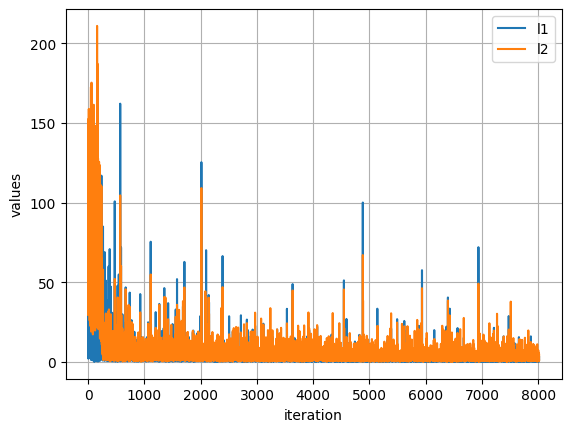

loss_df:               l1         l2        l3        l4         l5
0     21.844347  65.835800  0.000947  0.007919   6.065365
1      5.915811  33.681477  0.000332  0.008850   3.000592
2     12.476949  63.846844  0.000709  0.008550   5.035061
3     22.752958  82.195618  0.000756  0.008332   7.013250
4      0.953323  30.155266  0.000228  0.008240   2.029653
...         ...        ...       ...       ...        ...
8012   1.225446   2.775685  0.038586  0.988350   4.624569
8013   4.094457   4.817994  0.688772  0.685996   5.292946
8014   2.057270   3.385148  0.699883  0.791482  10.641878
8015   0.465456   1.273385  0.355141  0.697129   3.081600
8016   1.384980   1.649000  0.905187  0.792406   7.862127

[8017 rows x 5 columns]


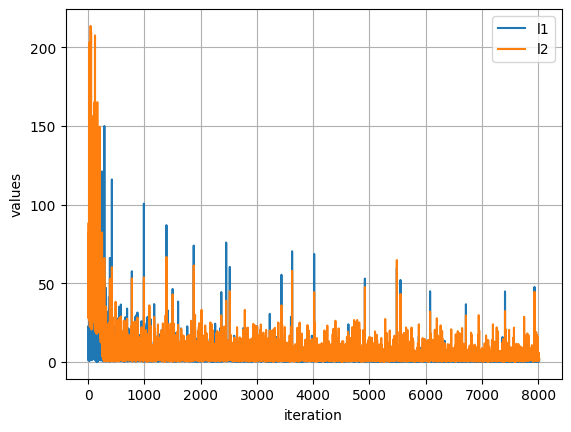

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
loss_dir = os.path.expanduser("~/Downloads")
for fname in ["/train_loss_latest.csv", "/val_loss_latest.csv"]:
    loss_df = pd.read_csv(loss_dir + fname, index_col=0)
    print("loss_df: ", loss_df)
    for col in loss_df.columns:
        if col == "l1" or col == "l2":
            plt.plot(loss_df[col], label=col)
    plt.xlabel("iteration")
    plt.ylabel("values")
    plt.legend()
    plt.grid(True)
    plt.show()